In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

# Student t distribution

- overview https://en.wikipedia.org/wiki/Student%27s_t-distribution
- log likelihood in scipy https://math.stackexchange.com/questions/3201571/log-likelihood-function-of-the-noncentral-t-distribution

A 'non-standard' or 'location-scale' t distribution has the following params:

- &nu; (int >=1) degrees of freedom
- &mu; mean & mode
- &tau; scale parameter



0.9814854860552614  should approx. equal  1.0
1.305987317203713  should approx. equal  1.2909944487358056


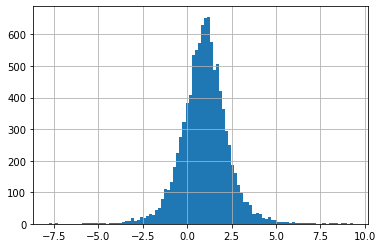

In [2]:
# generate some example data in numpy
mu = 1.0
tau = 1.0 # not the same as sigma because the standard t has variance nu/(nu-2), if this exists
nu = 5

eg = mu + np.random.standard_t(nu, size = 10000) * tau

print(np.mean(eg), " should approx. equal ", mu)
print(np.std(eg), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts, bins = np.histogram(eg, bins = 100)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.grid() # NB if we make nu smaller we get much fatter tails

0.9995857097328721  should approx. equal  1.0
1.2945879994033558  should approx. equal  1.2909944487358056


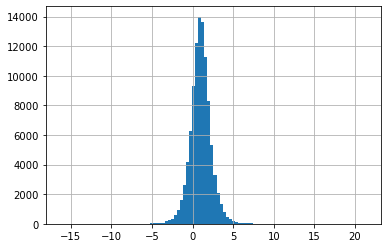

In [3]:
# scipy

from scipy.stats import t # non central t

eg2 = t.rvs(nu, loc = mu, scale = tau, size = 100000)

print(np.mean(eg2), " should approx. equal ", mu)
print(np.std(eg2), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts2, bins2 = np.histogram(eg2, bins = 100)
_ = plt.hist(bins2[:-1], bins2, weights=counts2)
plt.grid() # NB if we make nu smaller we get much fatter tails

# all looks fine

In [4]:
# log likelihood example (it's not very sensitive to dof!)
print(nu)
print(t(nu, loc = mu, scale = tau).logpdf(eg2).mean()) # actual
print(t(nu-2, loc = mu, scale = tau).logpdf(eg2).mean()) #different - should be lower
print(t(nu+2, loc = mu, scale = tau).logpdf(eg2).mean()) #different - should be lower
print(t(nu, loc = mu - 1.0, scale = tau).logpdf(eg2).mean()) #different - should be lower
print(t(nu, loc = mu, scale = tau * 2.0).logpdf(eg2).mean()) #different - should be lower
print(t(nu, loc = mu, scale = tau / 2.0).logpdf(eg2).mean()) #different - should be lower


5
-1.6304093377768762
-1.641982350729272
-1.6343822307229525
-1.9883130144381138
-1.8734211236627718
-1.9837899826866092


In [5]:
%timeit t(nu, mu, tau) #656 micros  SCIPY is slow to construct objects
%timeit t(nu, mu, tau).logpdf(eg2[:1]) # 905 micros
%timeit t(nu, mu, tau).logpdf(eg2[:1000]) #1070 micros 

690 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
963 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.13 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
# state and proposal
# NB make sure the state is hashable so the cache works
from scipy.stats import t
from numpy.random import seed, randn, rand, randint, shuffle

class StateT:
    def __init__(self, nu, mu = 0.0, tau = 1.0):
        self.nu = nu
        self.mu = mu
        self.tau = tau
        self.distrib = t(self.nu, loc = self.mu, scale = self.tau)
    def log_like(self, xs):
        return(self.distrib.logpdf(xs).sum())
    def __str__(self):
        return("Student t state variable: nu = {},  mu = {:.3f}, tau = {:.3f}".format(self.nu, self.mu, self.tau))


def proposalT(state, index=0): # index is not used here but the arg must be listed for HINTS
    new_nu = state.nu + randint(-1,+2) # displace by -1, 0 or 1
    new_mu = state.mu + 0.05 * randn()
    new_tau = state.tau * np.exp(0.05 * randn()) # random walk on log value    
    if new_nu == 0: # reflecting barrier at 1 d.o.f.
        new_nu = 2
    return(StateT(new_nu, new_mu, new_tau), 0.0) # construct a new state; symmetrical so Hastings correction (delta) is zero


x1 = StateT(nu, mu, tau)
print(x1)
print(x1.log_like(eg2)/len(eg2)) # should be same as above

print(proposalT(x1)[0])


Student t state variable: nu = 5,  mu = 1.000, tau = 1.000
-1.6304093377768762
Student t state variable: nu = 6,  mu = 1.078, tau = 0.983


In [7]:
# create the user function for HINTS to work with this
from functools import lru_cache
from HINTS_fn_simple import *  # will be much faster with vector evals due to scipy overheads

# Simple test function: Gaussian with per term bias
class TestFnT_OLD(UserFnSimple):
    def __init__(self, data):
        self.N = len(data)
        self.data = data
        super().__init__(proposalT)
        #
    def sample_initial_state(self):
        return(StateT(5, 0.0, 1.0)) # start with 5 dof
        #
    def evaluate_sequence(self, state, term_index, num_terms):
        return(self.cached_eval_sequence_fast(state, term_index, num_terms))
        #
    @lru_cache(maxsize = 1000000)    
    def cached_eval_sequence_fast(self, state, term_index, num_terms):
        #print("cache miss; evaluating ", term_index, num_terms)
        self.counter += num_terms
        return(state.log_like(self.data[term_index:term_index+num_terms]).sum())

# version that takes 2D data of size NUM_SCENARIOS x LEAF_SIZE
class TestFnT(UserFn):
    def __init__(self, data):
        self.N = data.shape[0]
        self.per_lead = data.shape[1]
        self.data = data
        super().__init__(proposalT)
        #
    def sample_initial_state(self):
        return(StateT(5, 0.0, 1.0)) # start with 5 dof
        #
    def evaluate(self, state, term_index, with_gradient = False):
        return(self.cached_eval_fast(state, term_index))
        #
    @lru_cache(maxsize = 1000000)    
    def cached_eval_fast(self, state, term_index):
        self.counter += 1
        return(state.log_like(self.data[term_index]).sum())

    
NUM_SCENARIOS = 256
LEAF_SIZE = 1024 ## vectorise at leaves for speed
data = t.rvs(nu, loc = mu, scale = tau, size = [NUM_SCENARIOS, LEAF_SIZE])
print(data.shape)
fn = TestFnT(data)

%time fn(x1, list(range(NUM_SCENARIOS)))/(NUM_SCENARIOS * LEAF_SIZE) # check we get the right log likelihood
%time fn(x1, list(range(NUM_SCENARIOS)))/(NUM_SCENARIOS * LEAF_SIZE)# run again to check cache is working


(256, 1024)
Wall time: 101 ms
Wall time: 0 ns


-1.6286272692769563

In [17]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults

if True: # put True in for HINTS, False for simple MCMC where evaluations use all data
    args.levels = 4
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 1000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 256
    args.design = np.array([NUM_SCENARIOS])
    iterations = 2000 # TO DO need to match actual evaluations (taking account of reuse in cache)

print(NUM_SCENARIOS)

# design now has levels + 1 entries
args.additive = True # natural for lok likelihoods in Bayesian inference
args.T = 1.0 #top level
args.dT = 0.0

print(args.__dict__)

256
{'levels': 4, 'design': array([1, 4, 4, 4, 4]), 'additive': True, 'T': 1.0, 'dT': 0.0}


In [18]:
data = t.rvs(nu, loc = mu, scale = tau, size = [NUM_SCENARIOS, LEAF_SIZE])
g = TestFnT(data)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)


RESET
4
[  1   4  16  64 256]
256
[1. 1. 1. 1. 1.]
Student t state variable: nu = 5,  mu = 0.000, tau = 1.000


In [19]:

# do not use t as a variable name!!
history = []
for tstep in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # show progress
    if ((tstep%100)==99):
        print(tstep+1, hmc.acceptances, hmc.rejections, hmc.fn.total_counter, hmc.fn.counter)
    #
    history.append({'nu':state.nu, 'mu':state.mu, 'tau':state.tau})

100 [7777 2569 1075  313   84] [17823  3831   525    87    16] 256000 63538
200 [15738  5083  2131   643   177] [35462  7717  1069   157    23] 512000 123356
300 [23500  7680  3179   970   255] [53300 11520  1621   230    45] 768000 189382
400 [31495 10217  4228  1305   342] [70905 15383  2172   295    58] 1024000 250363
500 [39307 12756  5285  1633   428] [88693 19244  2715   367    72] 1280000 312704
600 [47183 15314  6354  1967   516] [106417  23086   3246    433     84] 1536000 374608
700 [54947 17917  7414  2306   600] [124253  26883   3786    494    100] 1792000 436604
800 [62792 20527  8464  2643   685] [142008  30673   4336    557    115] 2048000 498504
900 [70527 23089  9518  2993   773] [159873  34511   4882    607    127] 2304000 558788
1000 [78261 25656 10599  3328   858] [177739  38344   5401    672    142] 2560000 619771


In [20]:
# acceptance statistics at each level in the tree
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[78261 25656 10599  3328   858]
[177739  38344   5401    672    142]
[0.30570703 0.400875   0.6624375  0.832      0.858     ]


In [21]:
print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))
# HINTS gives you fewwer samples but each is better mixed
# which is fine if you are going to marginalise 


Calls: 2,560,000; Missed cache: 619,771; Miss rate: 24%


In [22]:
import pandas as pd
samples = pd.DataFrame(history)

In [23]:
samples.describe() # looks good!
# HINTS seems tighter than MCMC but need to see whuch is the better _sample_

,nu,mu,tau
count,1000.0,1000.000000,1000.000000
mean,5.0,1.000671,0.999643
std,0.0,0.002482,0.001657
min,5.0,0.995433,0.990940
25%,5.0,0.998633,0.998517
50%,5.0,0.999970,0.999325
75%,5.0,1.003416,1.000242
max,5.0,1.006852,1.011447
